In [16]:
import os, sys, time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None
import h5py
import geopandas as gpd
sys.path.append(os.path.join(os.getcwd(),r'..\..\..'))
from input_configuration import base_year

%matplotlib inline

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [17]:
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

# Relative path between notebooks and goruped output directories
relative_path = '../../../outputs'
survey_path = '../../../inputs/base_year/survey'

In [18]:
pd.options.display.float_format = '{:0,.0f}'.format

# High Capacity Transit
List of Routes

Map of Routes

In [19]:
# List of Stations
# Load transit stops file

#"The definition we have been using for the RTP is BRT, LRT, Commuter Rail, StreetCar and Ferry."
df = pd.read_csv(r'T:\2021September\Stefan\transit_stops.csv')
# Streetcar is coded as light rail
df['hct'] = 0
df.loc[df[['commuter_rail','light_rail','ferry','brt']].sum(axis=1) > 0,'hct'] = 1
df_hct = df[df['hct'] == 1]
df_hct

,PSRCJunctID,x,y,bus,commuter_rail,light_rail,ferry,express,frequent,brt,hct
25,9369,"1,182,204","247,460",1,0,0,0,0,0,1,1
148,13175,"1,191,433","282,538",1,0,0,0,0,0,1,1
153,13329,"1,191,716","282,850",1,0,0,0,0,0,1,1
156,13488,"1,192,005","282,039",1,0,0,0,0,0,1,1
159,13779,"1,192,485","236,412",1,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
7556,198909,"1,268,392","280,768",1,0,0,0,0,0,1,1
7557,198911,"1,268,458","278,075",1,0,0,0,0,0,1,1
7560,198977,"1,304,632","248,490",1,0,0,0,0,0,1,1
7566,199217,"1,268,114","234,348",1,0,0,0,0,0,1,1


In [20]:
# Map of Stations
# Load as a geodataframe
gdf_hct = gpd.GeoDataFrame(
    df_hct, geometry=gpd.points_from_xy(df_hct.x, df_hct.y))

crs = {'init' : 'EPSG:2285'}
gdf_hct.crs = crs

# HCT Station Location

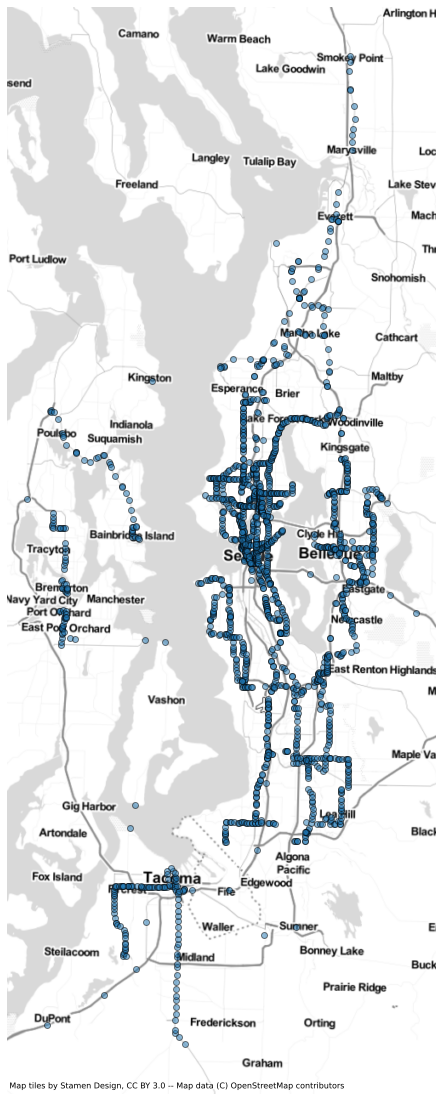

In [22]:
import contextily as ctx
ax = gdf_hct.plot(figsize=(20,20), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, crs=crs)
ax.set_axis_off()

In [23]:
# Export stops as a shapefile
gdf_hct.to_file('hct_stops.shp')

C:\Users\Modeller\Anaconda3\envs\summary\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  


# HCT Network
FIXME: input and output links are temporary

In [24]:
# df = pd.read_csv(r'..\..\..\outputs\transit\transit_line_results.csv')
df_segments = pd.read_csv(r'C:\Workspace\sc_2050_rtp\soundcast\inputs\scenario\networks\shapefiles\AM\AM_transit_segments.csv')
df = pd.read_csv(r'T:\2021September\Stefan\transit_stops.csv')
# Create a column that identifies HCT routes
df['hct'] = 0
df.loc[df[['commuter_rail','light_rail','ferry','brt']].sum(axis=1) > 0,'hct'] = 1
df_hct = df[df['hct'] == 1]
df_hct

def identify_hct_routes(df_segments, df_hct_stops):
    """Returns HCT routes as a list. HCT links are defined in the geodatbase based on the TransitType field.
       This field is not available on the network files so we use stop defintions, which are then linked to 
       transit segments. These segments are then associated with IJ network links. 
    """
    
    # Identify routes that have all stops flagged as HCT, using only segments with stops
    df_stop_segments = df_segments[df_segments['is_stop'] == 1]

    # Iterate through all transit lines and flag as an HCT route only if all 
    # stops on the line correspond to HCT stop locations - this avoids 
    # flagging non-HCT routes that share the same stop as HCT routes
    hct_routes = []
    for route_id in df_stop_segments['route_id'].unique():
        _df = df_stop_segments[df_stop_segments['route_id'] == route_id]
        if len(_df[_df['INode'].isin(df_hct['PSRCJunctID'])]) == len(_df):
            hct_routes.append(route_id)
            
    return hct_routes

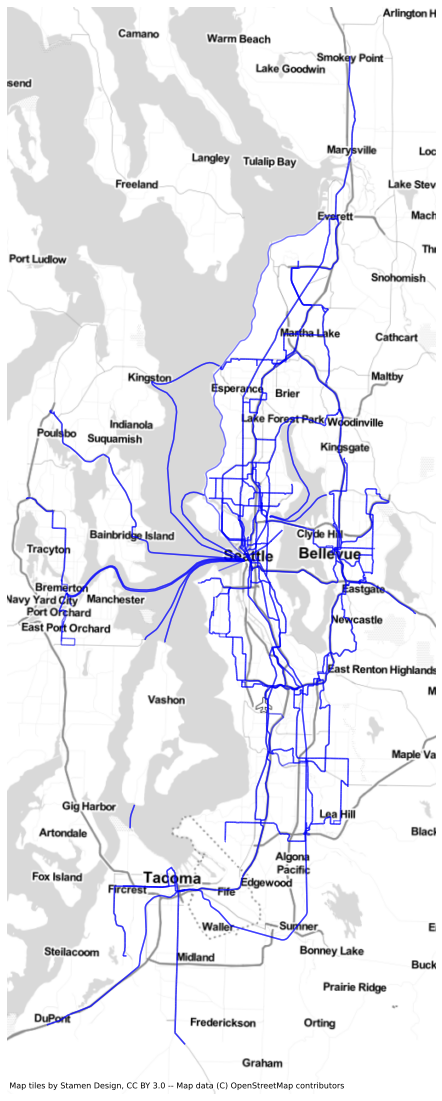

In [25]:
df_network = gpd.read_file(r'C:\Workspace\sc_2050_rtp\soundcast\inputs\scenario\networks\shapefiles\AM\AM_edges.shp')
hct_routes = identify_hct_routes(df_segments, df_hct)
hct_segments = df_segments[df_segments['route_id'].isin(hct_routes)]
hct_network = df_network[df_network['id'].isin(hct_segments['ij'])]
hct_network.crs = crs
ax = hct_network.plot(figsize=(10,20), alpha=0.5, edgecolor='b')
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, crs=crs)
ax.set_axis_off()

# People Living Near HCT Stations

In [26]:
df_lu = pd.read_csv(r'..\..\..\inputs\scenario\landuse\parcels_urbansim.txt',
                   delim_whitespace=True)

# Load as a geodataframe
gdf_lu = gpd.GeoDataFrame(
    df_lu, geometry=gpd.points_from_xy(df_lu.XCOORD_P, df_lu.YCOORD_P))

crs = {'init' : 'EPSG:2285'}
gdf_lu.crs = crs

parcel_geog = pd.read_sql_table('parcel_'+base_year+'_geography', 'sqlite:///../../../inputs/db/soundcast_inputs.db')

In [27]:
df_lu = df_lu.merge(parcel_geog,left_on='PARCELID', right_on='ParcelID')

In [28]:
def calculate_buffer(gdf_lu, gdf_network, distance):
    
    # Buffer the HCT station gdf
    gdf_network['geometry'] = gdf_network.buffer(distance)

    gdf_intersect = gpd.overlay(gdf_network, gdf_lu, how="intersection", keep_geom_type=False)
    df = df_lu[df_lu['PARCELID'].isin(gdf_intersect['PARCELID'].unique())]

    df = df.merge(parcel_geog,left_on='PARCELID', right_on='ParcelID')
    
    return df

In [29]:
def aggregate_parcels(df, col_dict, sum_field):
    results_df = pd.DataFrame()
    for col, name in col_dict.items():
        _df = df.groupby(col).sum()[[sum_field]]
        _df['group'] = name
        results_df = results_df.append(_df)
    results_df = results_df.reset_index()
    
    return results_df

In [30]:
df_025 = calculate_buffer(gdf_lu, gdf_hct, distance=5280.0/4)

In [170]:
df_050 = calculate_buffer(gdf_lu, gdf_hct, distance=5280.0/2)

In [32]:
df_025['HH_P'].sum()

418783

In [33]:
pd.options.display.float_format = '{:0,.0f}'.format
col_dict = {'racial_geog_vs_reg_total': 'Race',
                      'poverty_geog_vs_reg_total': 'Poverty',
                      'elderly_geog_vs_reg_total': 'Elderly',
                      'youth_geog_vs_reg_total': 'Youth'}

hct_hh_df = pd.DataFrame()
df = aggregate_parcels(df_025, col_dict, 'HH_P')
df['distance'] = 0.25
hct_hh_df = hct_hh_df.append(df)
df = aggregate_parcels(df_050, col_dict, 'HH_P')
df['distance'] = 0.50
hct_hh_df = hct_hh_df.append(df)

KeyError: 'racial_geog_vs_reg_total'

In [190]:
pd.options.display.float_format = '{:0,.1f}'.format
hct_df = hct_hh_df[hct_hh_df['index'] == 1].pivot_table(index='group',columns='distance', values='HH_P', aggfunc='sum')
hct_df

distance,0.2,0.5
group,,
Elderly,417141,501792
Poverty,487979,550292
Race,546441,623409
Youth,336697,433885


In [202]:
df = aggregate_parcels(df_lu, col_dict, 'HH_P')
df = df[df['index'] == 1]
df.rename(columns={'HH_P': 'Total'}, inplace=True)
df.drop('index', axis=1, inplace=True)

df = df.merge(hct_df, on='group')
df.index = df['group']
df[[0.25,0.5,'Total']]

,0.25,0.5,Total
group,,,
Race,546441,623409,718274
Poverty,487979,550292,674988
Elderly,417141,501792,757447
Youth,336697,433885,795701


In [206]:
# add total households 
df_025['HH_P'].sum()

952882

In [41]:
df

,PSRCJunctID,x,y,bus,commuter_rail,light_rail,ferry,express,frequent,brt,hct
0,7476,"1,175,474","189,648",1,0,0,0,0,0,0,0
1,7927,"1,177,461","229,644",1,0,0,0,0,0,0,0
2,7966,"1,177,591","223,118",1,0,0,0,0,0,0,0
3,7990,"1,177,630","225,389",1,0,0,0,0,0,0,0
4,8042,"1,177,793","225,983",1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
7563,199138,"1,310,504","404,171",1,0,0,0,0,0,0,0
7564,199215,"1,308,040","279,706",1,0,0,0,0,0,0,0
7565,199216,"1,308,052","279,638",1,0,0,0,0,0,0,0
7566,199217,"1,268,114","234,348",1,0,0,0,0,0,1,1


In [210]:
df_lu['HH_P'].sum()

1605263

In [185]:
# Calculate total number of households within equity groups
df = aggregate_parcels(df_lu, col_dict, 'HH_P')
df = df[df['index'] == 1]
df

,index,HH_P,group
2,1,718274,Race
5,1,674988,Poverty
8,1,757447,Elderly
11,1,795701,Youth


In [184]:
df

,index,HH_P,group
1,0,886989,Race
2,1,718274,Race
4,0,930275,Poverty
5,1,674988,Poverty
7,0,847816,Elderly
8,1,757447,Elderly
10,0,809562,Youth
11,1,795701,Youth


# Jobs Near HCT Stations

# Walk/Bike Facilities Near HCT Stations


In [ ]:
# calculate the miles of bike lanes and sidewalks within quarter nd half mile of all HCT stations
# will need to connect to Elmer to do this
# Buffer intersect with transRefEdges and load table
# somehow incorporate the equity geographies?
# Identify a station area as within/outside equity geog

BRT Routes + Congestion + TSP 
Map and TAble

Local Routes + Congestion + TSP

# Boardings by Stops
by Equity Geographies

In [ ]:
# There are over 1000 stops
# should we further refine this table?
# Do we want total stops or a map?
df_stops

# Access by Mode to HCT

In [ ]:
# Load daysim outputs - tour
# Link the transit trip portion a stop (?)

# Easy way is to get access mode for trips to 
# all stops with HCT without figuring out whether they took 
# an HCT route or not. Multiple other routes can use HCT
# stations. 